# A collection of examples showing how to carry out computations of 
# Protein-Ligand  Interaction Fingerprits, IFPs,  using MD-IFP tools for

## multiple MD trajectories, including  dissociation trajectories simulated  RAMD method

## Application example: GPCR embedded in a membrane

    GPCR - Muscarinic Receptor M2 in a membrane
    Membrane containing cholesterol 50%  + POPC + POPE and M2 muscarinic receptor (PDB ID=4MQT)
    
    
    
 
### Input data required:
    MD trajectory file of a complex
    pdb file of a complex (for example, generated from the first frame)
    pdb and mol2 file of a ligand separately 
    Data can be downloaded from https://zenodo.org/record/3755337#.XrF-iGgzaUk
    
    
### Packages required:
    numpy
    matplotlib
    MDAnalysis v. 20.1 or above
    pandas
    seaborn
    RDkit
    nglview
    code is written on Python 3.x and tested on the version 3.7



### v 1.0
    06.06.2020
    Copyright (c) 2020
    Released under the EUPL Licence, v1.2 or any higher version
    
### Authors: Daria Kokh & Fabian Ormersbach 
    Daria.Kokh@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany
    

Before we start, let us import the required scripts and packages.

In [42]:
import MDAnalysis as mda
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from rdkit import Chem
import nglview as nv

##  1. Computation of PL IFPs  for a single dcd trajectory

    Generation of PL IFP  for a membrane protein bound to a ligand (muscarinic receptor M2; PDB:4MQT)
    
    Data used:
    PDB file of a complete system equilibrated using AMBER
    MD trajectory in DCD format (generated using NAMD software)
    ligand PDB and Mol2 files 
    (Important: not all Mol2 formats can be read by RDKit, file generated by MOE software works well)
    
    Result:
    A dataframe (df_prop_complet) will be generated; it contains PL IFP for each frame analyzed


### 1.1 Data preparation and loading a MD trajectory

In [43]:
# Define the path to our input data
ref =  "Data/4MQT/AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
traj = "Data/4MQT/RAMD/Replica1/Traj1/ORTO-CHL_108_ramd_016.dcd"
ligand_pdb = "Data/4MQT/IXO.pdb"
ligand_mol2 = "Data/4MQT/moe.mol2"

# Define the part of the trajectory we will analize
start = 200
stop = -1
step = 10

# Load the trajectory into an MDAnalysis universe
u = mda.Universe(ref,traj)
print("the total length of trajectory: ",len(u.trajectory)," frames")

# Define the identifier of the ligand we want to analize
sel_ligands = "IXO"

# Define a sub-system we wish to analize (we are going to exclude membrane residues now for faster compution)
u_reduced = u.select_atoms(" protein or (resname WAT SOL HOH "+sel_ligands+")")

# Load part of the trajectory into memory
u_mem = mda.Merge(u_reduced).load_new(AnalysisFromFunction(
                    lambda ag: ag.positions.copy(), u_reduced).run(
                        start=start,stop=stop,step=step).results,format=MemoryReader)
print('Will be analized: ', len(u_mem.trajectory), 'frames')

the total length of trajectory:  721  frames
Will be analized:  52 frames


### 1.2  Generation of ligand properties 

        For this functions of the Ligand class is used. They are mainly based on the RDKit library to detect standard physical/chemical properties of the ligand functional groups and atoms.
    Details about the definition of the RDKit properties can be found at https://github.com/rdkit/rdkit/blob/master/Data/BaseFeatures.fdef. 

    Additionally, hydrophobic properties of F atoms and ionazable H-acceptor properties of PO3 groups (which are not included in th RDKit) will be added.


Atoms found in the MOL2 file:  ['C01', 'N02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'O09', 'C10', 'N11', 'O12', 'C13', 'C14', 'H011', 'H012', 'H013', 'H031', 'H032', 'H033', 'H041', 'H042', 'H043', 'H051', 'H052', 'H081', 'H082', 'H131', 'H132', 'H141', 'H142']
...............Ligand properties:................
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
............Important! ........
The following residue names will be used to identify ligand in the PDB file:  ['IXO']
Ligand properties:  {'Acceptor': ['O09', 'O12'], 'PosIonizable': ['N02'], 'Hydrophobe': ['C14', 'C06', 'C07']}


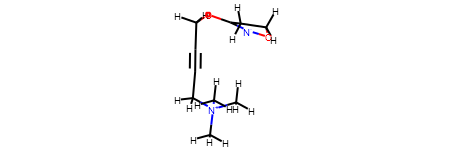

In [44]:
my_ligand = Ligand("./",ligand_pdb,ligand_mol2)
properties = my_ligand.property_list
print("Ligand properties: ",properties)
my_ligand.mol

### 1.3 Generation of  PL IFPs  for a single trajectory (this may take about 5-10 min)

    additionally will be  reported:

    (i) the number of water molecules in the ligand solvation shell
    (ii) all residues around the ligand within 4A (RE=True)


In [45]:
# Compute the IFP
df_prop,df_HB,df_WB = IFP(u_mem, sel_ligands, properties, WB_analysis=True, RE=True, Lipids= [])

# Merge the data into one dataframe
df_prop_complete = table_combine(df_HB, df_WB, df_prop, sel_ligands)

# Plot the finished table (left plot - IFPs, middle plot- PL contacts (RE), right plot - number of water molecules in the water shell)

print(" List of all computed parameters (IFPS and others):\n",df_prop_complete.columns.values)


Start HB analysis 14:54:36.303088
Start WB analysis 14:54:44.150603
Start collecting IFPs:  14:55:08.196931
Start building IFP table:  15:00:34.671592
IFP database is ready  15:00:34.791526
 List of all computed parameters (IFPS and others):
 ['time' 'AR_TYR62' 'HY_TYR62' 'RE_TYR62' 'AR_TYR65' 'RE_TYR65' 'RE_TRP71'
 'AR_TRP81' 'HY_TRP81' 'RE_TRP81' 'HY_LEU82' 'RE_LEU82' 'IP_ASP85'
 'RE_ASP85' 'AR_TYR86' 'HY_TYR86' 'RE_TYR86' 'RE_SER89' 'WB_SER89'
 'HY_ASN90' 'RE_ASN90' 'HY_VAL93' 'RE_VAL93' 'HD_TRP137' 'HY_TRP137'
 'RE_TRP137' 'RE_CYX158' 'RE_TYR159' 'HY_ALA176' 'RE_ALA176' 'RE_PHE177'
 'RE_PHE232' 'HY_TRP236' 'RE_TRP236' 'HY_TYR239' 'RE_TYR239' 'AR_TYR239'
 'WB_TYR239' 'HD_ASN240' 'RE_ASN240' 'WB_ASN240' 'HY_TYR262' 'HD_TYR262'
 'AR_TYR262' 'RE_TYR262' 'RE_TRP263' 'RE_LEU264' 'HY_CYS265' 'RE_CYS265'
 'HY_TYR266' 'RE_TYR266' 'WAT']


### 1.4 Visualization of detected IFPs

    The first plot shows the devlopment of detected IFPs over the time of the trajetorie.  
    The second plot shows all contacts between ligand and protein over the time of the trajectorie.  
    The third plot shows the number of water molecules in a water shell of the ligand.

# Generation and analysis of Ligand-Protein Interaction Fingerprints ,IFPs, from MD trajectories
## Example:  muscarinic receptor M2 bound to iperoxo. 

    1. Computation of PL IFPs for a single dcd trajectory
    2. Computation  of IFP for a set of trajectories using a trajectory object :
        - Computation of PL IFPs for all equilibration trajectories
        - Computation of PL IFPs for all dissociation trajectories 
    here dcd trajectories are used as an example, but other formats (xtc, nc) can be used as well


### v 1.0
    06.06.2020
    Copyright (c) 2020
    Released under the GNU Public Licence, v2 or any higher version
    
### Authors: Daria Kokh & Fabian Ormersbach 
    Daria.Kokh@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany
    
    
### Input data required:
    - trajectory file 
    - pdb file (for example, generated from the first frame)
    - ligand mol2 and pdb files
    Data can be downloaded from https://zenodo.org/record/3755337#.XrF-iGgzaUk
    
    All examples are  provided in the Data directory:
        - Data/2YKI  - an example of the  analysis of a single PDB file 
        - Data/6EI5/ - an example of the analysis of a single trajectory
        - Data/4MQT/ - an example of the analysis of several trajectories obtained from RAMD simulations
    
### Packages required:
    numpy
    pandas
    matplotlib
    MDAnalysis v. 20.1 or above
    RDkit
    scipy
    nglview
    code is written on Python 3.x and tested on Python 3.7




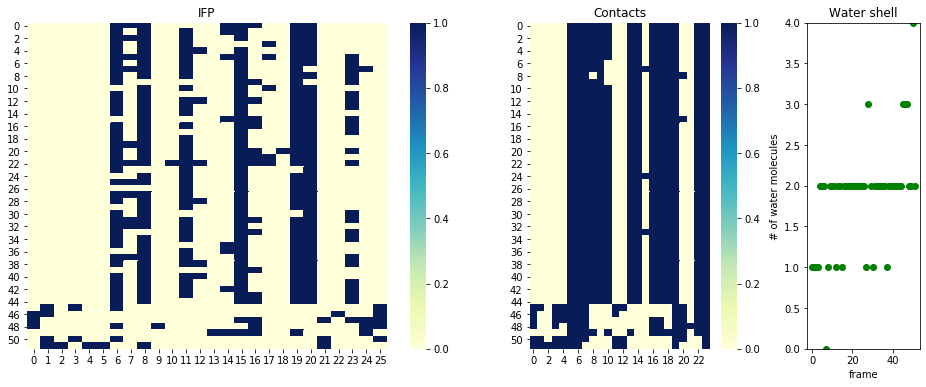

In [46]:
Plot_IFP(df_prop_complete)

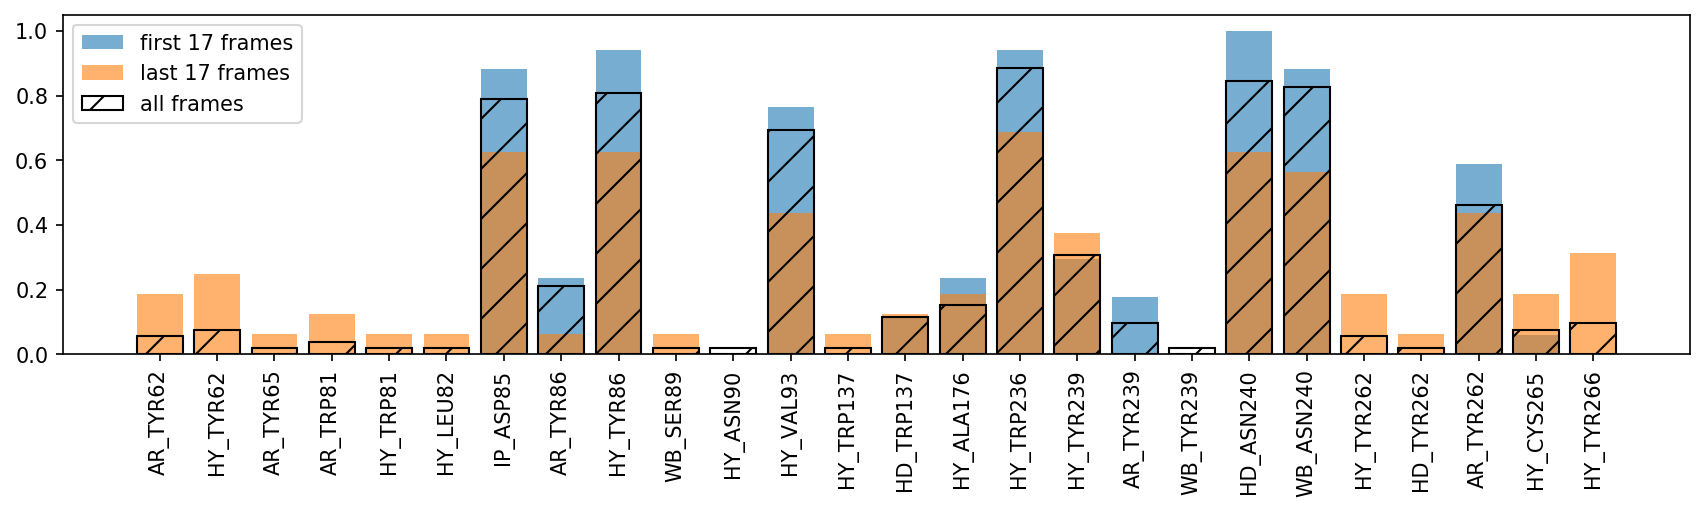

In [47]:
# Alternative way to plot detected IFPs: average IFPs value are shown for the first and last parts of the trajectory and for a whole trajectory
Plot_IF_trajectory(df_prop_complete,head_tail=-1)

## 2. Computation  of IFP using a trajectory object

In addition to the functions presented in 1.2 , we offer the option of performing all of the above in the scope of the trajectories class.  
Note that we start analyzing only after the last 200/300 frames and the ligand is moving out of the binding pocket, which is the reason for the large RMSD.

### 2.1 Instantiate a trajectory object

#### first we have to build an object that will contain all trajectories found by using a given pathway

In [31]:
# Define the path to the stored data
DIR_all = "Data/4MQT/"
DIR_ramd = "RAMD/Replica*"
DIR_namd = "NAMD_eq/Replica1*"
ref_pdb =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
ligand_pdb = "IXO.pdb"
ligand_mol2 = "moe.mol2"

# Instantiate the trajectorie object with the paths/ filenames for the data
tr = trajectories(DIR_all,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd, ligand_pdb=ligand_pdb,
                  ligand_mol2=ligand_mol2,ramd_traj_tmpl = "Traj*/*dcd",pdb = ref_pdb, timestep = 1)

Atoms found in the MOL2 file:  ['C01', 'N02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'O09', 'C10', 'N11', 'O12', 'C13', 'C14', 'H011', 'H012', 'H013', 'H031', 'H032', 'H033', 'H041', 'H042', 'H043', 'H051', 'H052', 'H081', 'H082', 'H131', 'H132', 'H141', 'H142']
...............Ligand properties:................
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
............Important! ........
The following residue names will be used to identify ligand in the PDB file:  ['IXO']
Ligand atoms found in the trajectory  IXO
ligand name:       IXO
1  Equilibration trajectories found
2  RAMD traj. found in  Data/4MQT//RAMD\Replica1
2  RAMD traj. found in  Data/4MQT//RAMD\Replica2


### 2.2 Computation of PL IFPs for all equilibration trajectories (takes about 15 min)

#### i. Since there are no water bridges in the present structure (see results of the section 1.2) we can speed up simulations by excludion water completely. For this we will re-define the variable sub_system of the trajectory object.
#### ii. IFPs for the last MD 300 frames  with the stride of 3 will be simulated
#### iii. the following additional properties will be computed:

    (i) all residues around the ligand within 4A (RE=True)
    (ii) the number of ligand contacts with specific residues, in this case - two kinds of the lipid residues (Lipids= ["CHL", "PA"])
    (iii) RMSD of four protein framents (see auxi_selection)

For the following diagram line 0-3 represent RMSD addition selections provided by auxi_selection list. 



>>>>>>>>>>>>>>>>> Replica:  Data/4MQT//NAMD_eq\Replica1\ORT-CHL_repl.dcd 

total number of frames= 1418; file size 1934 M
>>>sub-system selected  (resname IXO) or  protein or (resname MG MN CA Mg Mn) or (resname WAT HOH SOL) or ( resname  CHL PA PC )  or ((resid 8:21) and (not type H)) or ((resid 48:65) and (not type H)) or ((resid 88:91) and (not type H)) or ((resid 151:157) and (not type H))
will be analyzed  100 frames
traj# 0 RMSD protein:  1.3730883418270268 RMSD ligand:  0.9872856069944753 ligand residue name IXO
Start HB analysis 14:57:12.575444
Start WB analysis 14:57:26.720321
Start collecting IFPs:  14:58:09.662736
Start building IFP table:  15:08:49.995172
IFP database is ready  15:08:50.154100


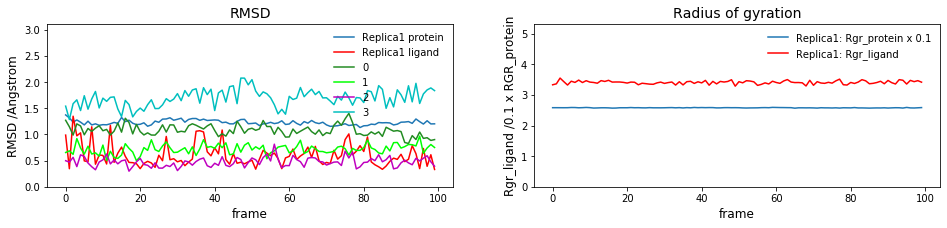

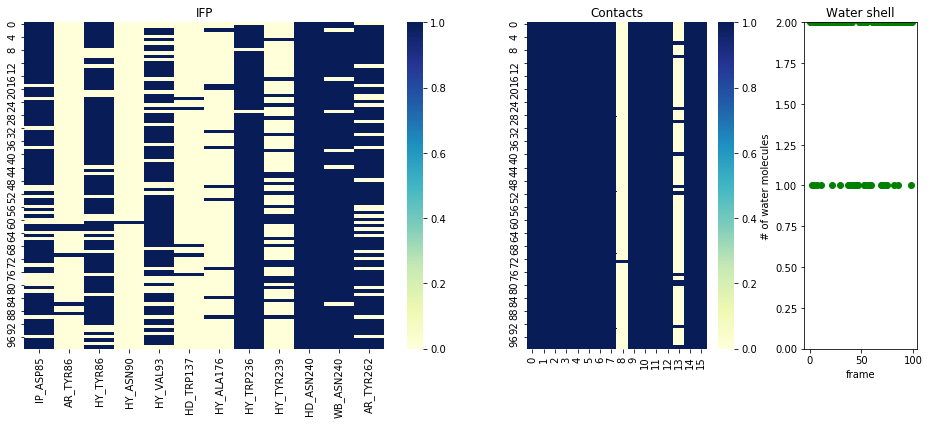

#  Replica: 0 Replica1


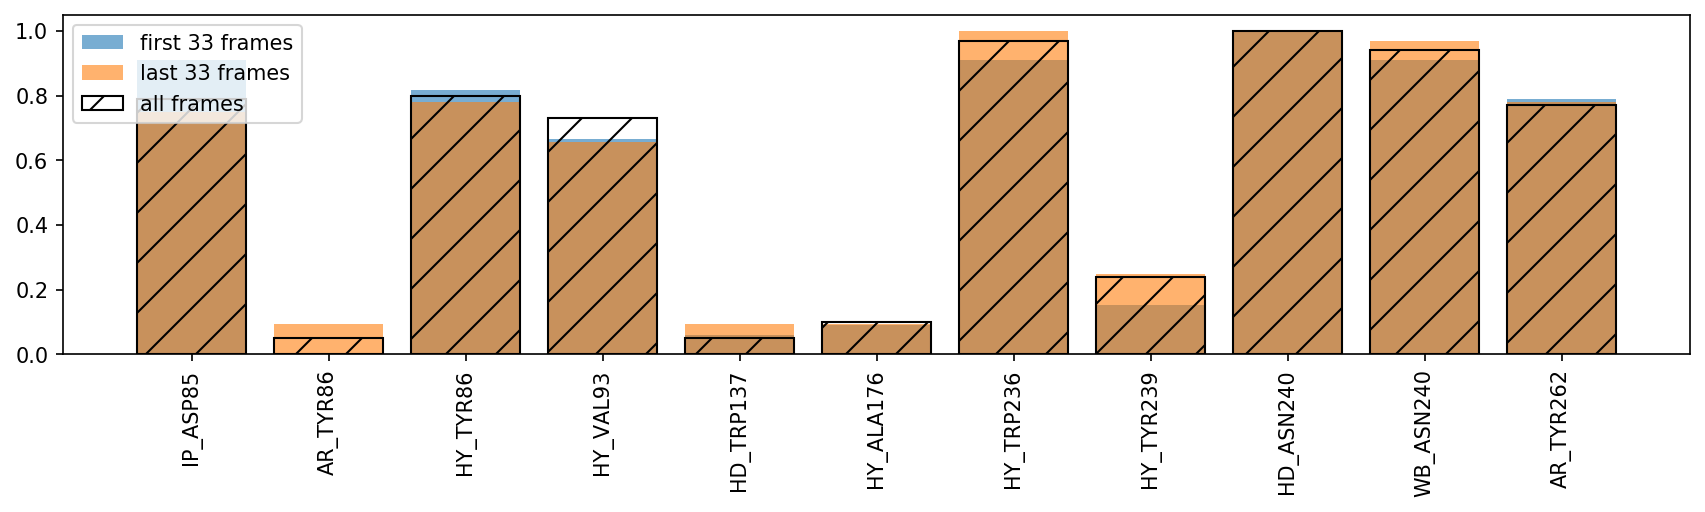

In [32]:
# name of the output file with IFP dataset 
out_name = 'ORTO-CHL-lipid14'

# here we define residues to be used to compute RMSD
auxi_selection = ["((resid 8:21) and (not type H))","((resid 48:65) and (not type H))","((resid 88:91) and (not type H))","((resid 151:157) and (not type H))"]

# re-define part of the system to use in computations; ligand and the list of Lipids will be added automatically
#tr.sub_system = " protein "

end = -300 
step =3 
# We start the analysis of the namd data and define ...
tr.analysis_all_namd(WB_analysis = True, Lipids = ["CHL", "PA", "PC"],auxi_selection = auxi_selection,step_analysis=step, start_analysis=end)

# Save and visualize the IFP dataframe to the specified location
# In the RMSD plot, in addition to the protein and ligand (heavy atoms) RMSD, also RMSD of the protein fragments given as an input (auxi_selection) are shown
IFP_table = tr.namd.IFP_save(tr.PRJ_DIR+out_name+"_NAMD_com.pkl")

# Alternative plot of detected IFPs in the first and last parts of the trajectory and on average

Plot_IF_trajectory(IFP_table,head_tail=-1)


### 2.3 Computation of PL IFPs for all dissociation trajectories (takes about 30 min) 

    (i) Only two RAMD trajectories will be analyzed (200 last frames)
    Note that relative residence time will be not computed because this would require least 10 RAMD trajectories . 

In [33]:
import MDAnalysis as mda
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from rdkit import Chem

# Define the path to the stored data
DIR_all = "Data/4MQT/"
DIR_ramd = "RAMD/Replica*"
DIR_namd = "NAMD_eq/Replica*"
ref_pdb =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
ligand_pdb = "IXO.pdb"
ligand_mol2 = "moe.mol2"
name  = "M2"

# Instantiate the trajectorie object with the paths/ filenames for the data
tr = trajectories(DIR_all,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd, ligand_pdb=ligand_pdb,
                  ligand_mol2=ligand_mol2,ramd_traj_tmpl = "Traj*/*dcd",pdb = ref_pdb, timestep = 1)

Atoms found in the MOL2 file:  ['C01', 'N02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'O09', 'C10', 'N11', 'O12', 'C13', 'C14', 'H011', 'H012', 'H013', 'H031', 'H032', 'H033', 'H041', 'H042', 'H043', 'H051', 'H052', 'H081', 'H082', 'H131', 'H132', 'H141', 'H142']
...............Ligand properties:................
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
............Important! ........
The following residue names will be used to identify ligand in the PDB file:  ['IXO']
Ligand atoms found in the trajectory  IXO
ligand name:       IXO
1  Equilibration trajectories found
2  RAMD traj. found in  Data/4MQT//RAMD\Replica1
2  RAMD traj. found in  Data/4MQT//RAMD\Replica2


!!!! RAMD trajectory set for Replica1 is too small (2 traj.), tau will not be computed for this replica 
!!!! RAMD trajectory set for Replica2 is too small (2 traj.), tau will not be computed for this replica 


>>>>>>>>>>>>>>>>> Replica  0 :  Replica1 

>>>>>>>>>= 0 Data/4MQT//RAMD\Replica1\Traj1\ORTO-CHL_108_ramd_016.dcd
total number of frames= 721; file size 983 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.7944282519744854 RMSD ligand:  1.5528813967099457 ligand residue name IXO
for the frame 42 ligand RMSD is very large: 10.060345408600618
for the frame 43 ligand RMSD is very large: 11.29884853884316
for the frame 44 ligand RMSD is very large: 11.082218769004662
for the frame 45 ligand RMSD is very large: 11.989889151411315
for the frame 46 ligand RMSD is very large: 13.664263392288248
for the frame 47 ligand RMSD is very large: 15.244168342244368
for the frame 48 ligand RMSD is very large: 19.35

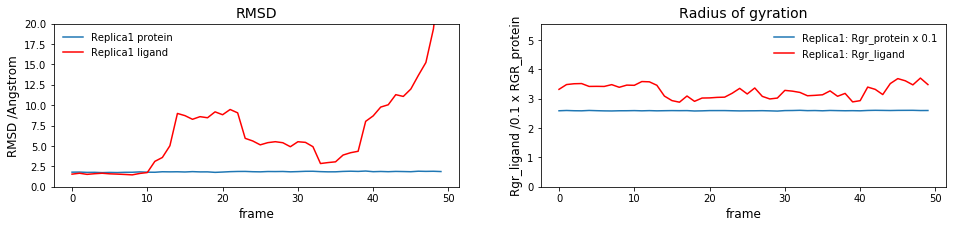

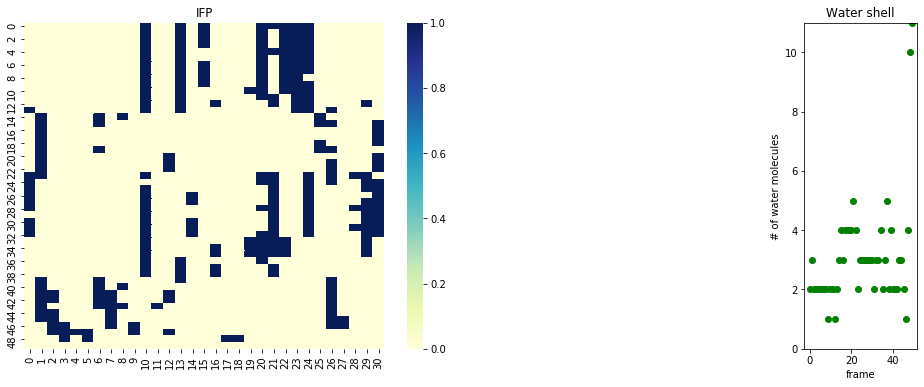

>>>>>>>>>= 1 Data/4MQT//RAMD\Replica1\Traj2\ORTO-CHL_104_ramd_016.dcd
total number of frames= 452; file size 616 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.7455431202017444 RMSD ligand:  1.446788182764909 ligand residue name IXO
for the frame 44 ligand RMSD is very large: 10.504850361395674
for the frame 45 ligand RMSD is very large: 11.153463897281531
for the frame 46 ligand RMSD is very large: 11.285078970300532
for the frame 47 ligand RMSD is very large: 14.6125950120132
for the frame 48 ligand RMSD is very large: 19.2708384756754
for the frame 49 ligand RMSD is very large: 27.7203055930756
Start HB analysis 15:17:13.270313
Start WB analysis 15:17:19.826556
Start collecting IFPs:  15:17:47.742891
Start building IFP table:  15:22:14.689127
IFP database is ready  15:22:14.706124


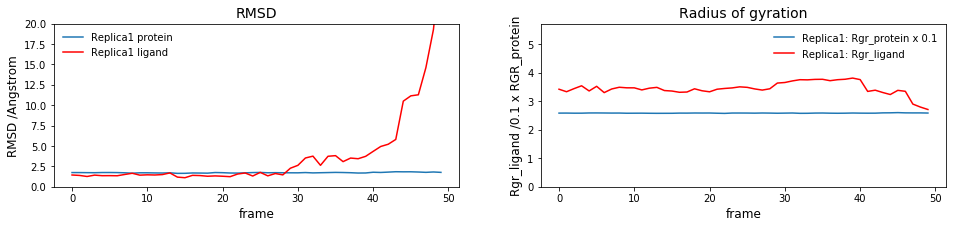

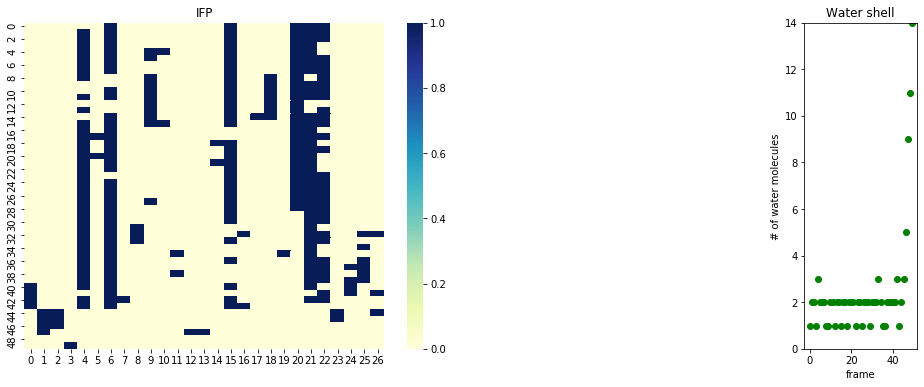



>>>>>>>>>>>>>>>>> Replica  1 :  Replica2 

>>>>>>>>>= 0 Data/4MQT//RAMD\Replica2\Traj1\ORTO-CHL_111_ramd_016.dcd
total number of frames= 144; file size 196 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.980573157048027 RMSD ligand:  1.3151278859753737 ligand residue name IXO
for the frame 48 ligand RMSD is very large: 15.562495239382967
for the frame 49 ligand RMSD is very large: 23.35323142486338
Start HB analysis 15:23:51.301141
Start WB analysis 15:23:59.221185
Start collecting IFPs:  15:24:25.907879
Start building IFP table:  15:29:01.626728
IFP database is ready  15:29:01.642716


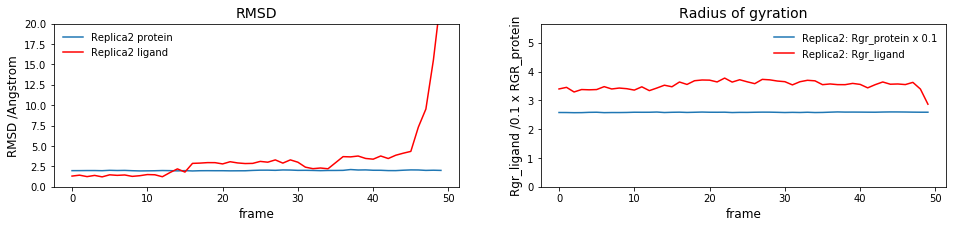

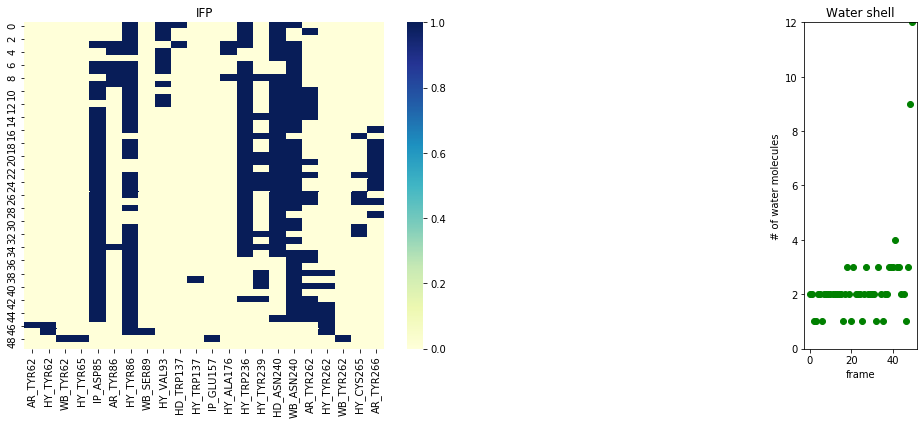

>>>>>>>>>= 1 Data/4MQT//RAMD\Replica2\Traj2\ORTO-CHL_105_ramd_016.dcd
total number of frames= 405; file size 552 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.8441344602082994 RMSD ligand:  1.5553976154512552 ligand residue name IXO
for the frame 25 ligand RMSD is very large: 10.866057163141951
for the frame 26 ligand RMSD is very large: 12.089188053984627
for the frame 27 ligand RMSD is very large: 14.047216349166417
for the frame 28 ligand RMSD is very large: 15.100338030102748
for the frame 29 ligand RMSD is very large: 15.289352515381978
for the frame 30 ligand RMSD is very large: 15.43331081969671
for the frame 31 ligand RMSD is very large: 15.302516647481482
for the frame 32 ligand RMSD is very large: 15.400237057347208
for the frame 33 ligand RMSD is very large: 15.465616885092096
for the frame 34 ligand RMSD is very large: 15.93864083783456
for the frame 35 ligand RMSD is very large: 15.847314

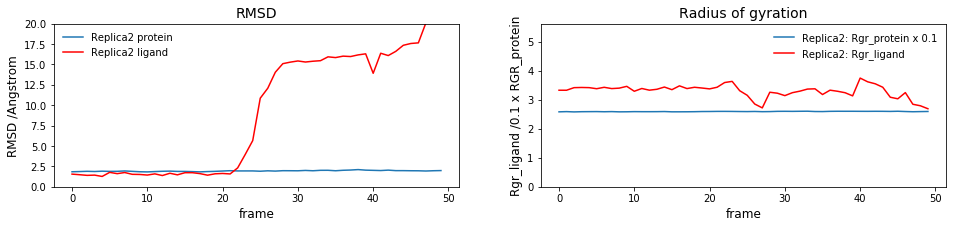

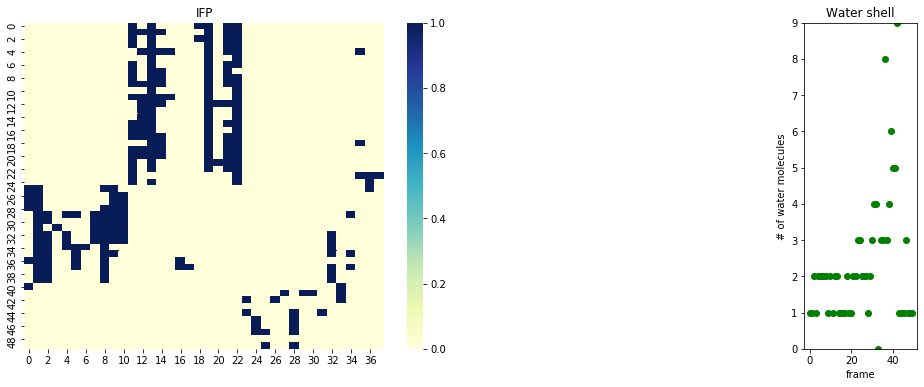

++++Will be saved +++++ ['Replica1', 'Replica2']


,time,AR_TYR62,HY_TYR62,AR_TYR65,HY_TYR65,AR_TRP71,HY_TRP71,AR_TRP81,HY_TRP81,WB_TRP81,...,WB_TYR62,WB_TYR65,WAT,Repl,Traj,RMSDl,RMSDp,RGyr,length,COM
0,0,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.552881,1.794428,3.320584,721,"[46.6, 47.04, 59.46]"
1,1,0,0,0,0,0,0,0,0,0,...,0,0,3,Replica1,0,1.662644,1.805608,3.483078,721,"[46.69, 46.54, 59.33]"
2,2,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.523883,1.767747,3.510939,721,"[46.66, 46.82, 59.45]"
3,3,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.605563,1.775628,3.517285,721,"[46.7, 46.66, 59.28]"
4,4,0,0,0,0,0,0,0,0,0,...,0,0,2,Replica1,0,1.663392,1.737660,3.419742,721,"[46.76, 46.83, 59.13]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,45,0,0,0,0,0,0,0,0,0,...,0,0,1,Replica2,1,17.575248,1.969224,3.031356,405,"[60.43, 45.01, 48.97]"
46,46,0,0,0,0,0,0,0,0,0,...,0,0,3,Replica2,1,17.652291,1.964150,3.244653,405,"[61.05, 45.15, 49.58]"
47,47,0,0,0,0,0,0,0,0,0,...,0,0,1,Replica2,1,20.099481,1.936687,2.843083,405,"[63.36, 45.32, 48.5]"
48,48,0,0,0,0,0,0,0,0,0,...,0,0,1,Replica2,1,21.420858,1.970441,2.791120,405,"[64.69, 45.55, 48.09]"


In [34]:
# Read the RAMD trajectories
tr.ramd.scan_ramd()

tr.sub_system = " protein or (resname HOH WAT SOL) "
# Compute the IFPs for the RAMD dissociation trajectories
tr.analysis_all_ramd(WB_analysis = True, RE= False, step_analysis=2, start_analysis=-100)

# Safe the IFP dataframe to the specified location
tr.ramd.IFP_save(tr.PRJ_DIR+name+"_RAMD_com.pkl")

### 2.4 Loading back the generated IFP table and plotting it

    The generated table can be then loaded from the the file and analyzed

In [35]:
IFP_data = pd.read_pickle(tr.PRJ_DIR+name+"_RAMD_com.pkl")


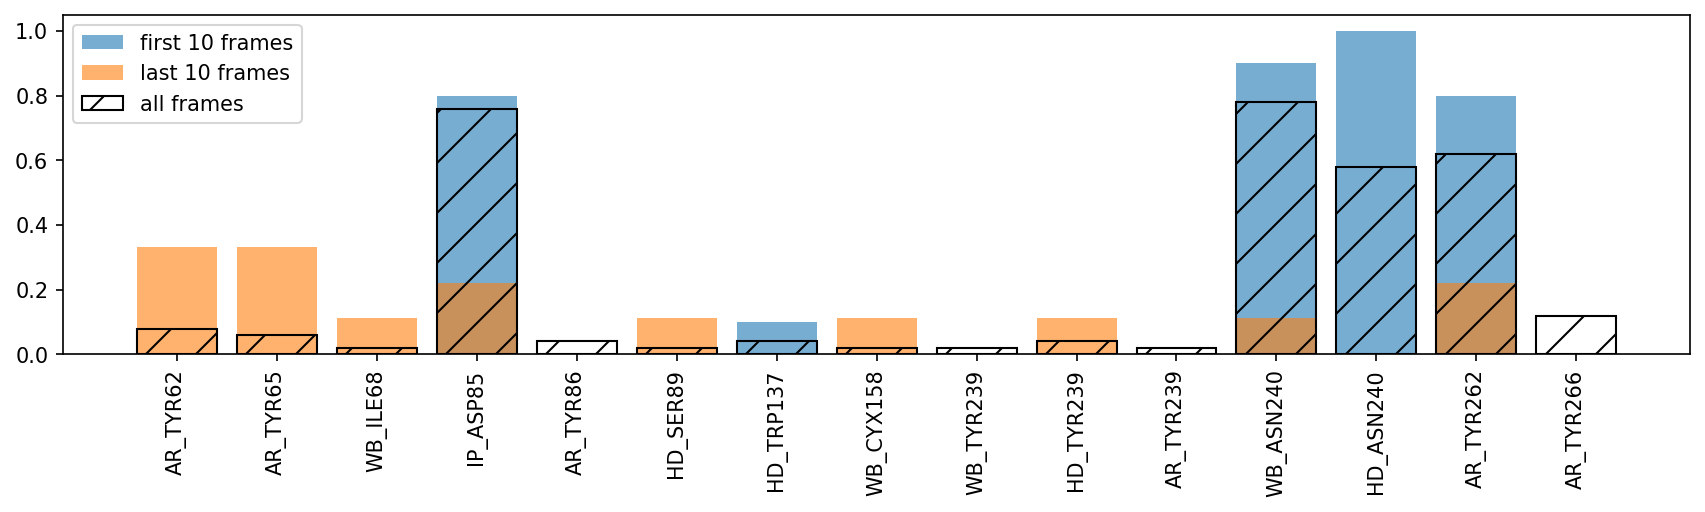

In [36]:
IFP_data_Repl1 = IFP_data[((IFP_data.Repl == "Replica1") )]
Plot_IF_trajectory(IFP_data_Repl1[(IFP_data_Repl1.Traj == "1")],ifp_type = np.asarray(['AR','HA','HD','IP','IN',"IO","WB"]),head_tail=10)